# ResNets

This week we discussed ResNets which are convolutional neural networks but with a residual learning framework realized by creating residual blocks via shortcut connections. In this notebook, we'll be implementing a fully connected NN, a plain CNN and a residual network and comparing the results on the MNIST dataset.

We'll start off by loading the data:

In [1]:
import torch
from torch import nn
import numpy as np
from sklearn.datasets import fetch_openml
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from torch import optim
import matplotlib.pyplot as plt

%matplotlib notebook

# Load the dataset... This can take a while
if("mnist" not in globals()):  # Don't load the dataset twice...
    mnist = fetch_openml('mnist_784', version=1)
    # Convert DataFrame to 24x24 numpy arrays...
    imgs = mnist.data.to_numpy().reshape(70000, 28, 28).astype(np.float32)
    # Labels for the mnist data, 0-9 being the number...
    labels = np.asarray(mnist.target).astype(int)
    
    imgs_train, imgs_test, labels_train, labels_test = train_test_split(
        imgs, labels, test_size=0.2, random_state=1
    )

Let's plot one of the digits at random.

<IPython.core.display.Javascript object>


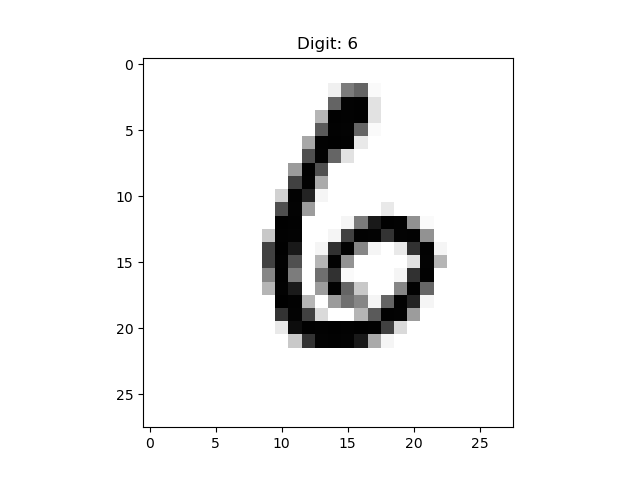

In [2]:
idx = np.random.randint(0, imgs.shape[0])
single_digit = imgs[idx]
single_label = labels[idx]

plt.title(f"Digit: {single_label}")
plt.imshow(single_digit, cmap="Greys")
plt.show()

We'll use a GPU to run these models. We'll check if one is available and assign it to our device.

In [3]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda") # GPU
else:
    device = torch.device("cpu") # CPU
    
print(f"Running PyTorch Using: {device}")

Running PyTorch Using: cuda


Now we'll prepare our data for training and testing using Pytorch's DataLoader which will pass in samples in “minibatches” and reshuffle the data at every epoch to reduce model overfitting. 

In [4]:
# Set the batch size: (Will be set to None in the final version)
batch_size = 50

# Set up data loaders, these will be used to train and test models...
to_device = lambda a: torch.from_numpy(a).to(device)

train_loader = data_utils.DataLoader(
    data_utils.TensorDataset(to_device(imgs_train), to_device(labels_train)),
    batch_size = batch_size,
    shuffle = True
)

test_loader = data_utils.DataLoader(
    data_utils.TensorDataset(to_device(imgs_test), to_device(labels_test)),
    batch_size = batch_size,
    shuffle = True
)

## Simple Model: Fully Connected NN

Now that we have our data set-up, let's start to implement our first network: a fully connected neural network.

In [5]:
class SimpleNet(nn.Module):
    def __init__(
        self, 
        img_w: int, 
        img_h: int, 
        hidden_layer_sizes: list, 
        class_size: int
    ):
        super().__init__()
        
        self._in_layer = nn.Linear(img_w * img_h, hidden_layer_sizes[0])
        
        layers = []
        for hls1, hls2 in zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:]):
            layers.extend([nn.Linear(hls1, hls2), nn.ReLU()])
        
        self._hidden_layers = nn.Sequential(*layers)
        
        self._out_layer = nn.Linear(hidden_layer_sizes[-1], class_size)
        self._softmax = nn.Softmax(dim=1)
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        x = x.reshape(-1, img_w * img_h)
        
        x = self._in_layer(x)
        x = self._hidden_layers(x)
        return self._softmax(self._out_layer(x))

Let's define some variables to use with our simple network.

In [72]:
# Set these! (We'll replace these with None in the final version...)
img_w = 28
img_h = 28
hidden_layer_sizes = [1000, 500, 100]  # List of None
class_size = 10

simple_net = SimpleNet(img_w, img_h, hidden_layer_sizes, class_size)
simple_net.to(device)

SimpleNet(
  (_in_layer): Linear(in_features=784, out_features=1000, bias=True)
  (_hidden_layers): Sequential(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=100, bias=True)
    (3): ReLU()
  )
  (_out_layer): Linear(in_features=100, out_features=10, bias=True)
  (_softmax): Softmax(dim=1)
)

We also want some functions to see how our netowrk performs. These are defined below:

In [117]:
# Functions for training a model...
def train_model(
    model, 
    train_data, 
    test_data, 
    optimizer, 
    error_func, 
    n_epochs, 
    augment_method=None, 
    print_every=300
):
    for epoch_i in range(1, n_epochs + 1):
        for i, (img, label) in enumerate(train_data, 1):
            model.zero_grad()
            predicted = model.forward(img if(augment_method is None) else augment_method(img))
            loss = error_func(predicted, label)
            loss.backward()
            optimizer.step()
            
            if((i % print_every == 0) or (i == len(train_data))):
                print(f"Epoch: {epoch_i}/{n_epochs}, Iter: {i}/{len(train_data)}, Loss: {loss:.04f}")
                
        # Run against the test set at the end of each epoch to get accuracy...
        acc1 = get_accuracy(model, train_data, augment_method)
        print(f"Epoch {epoch_i} Train Accuracy: {acc1 * 100:.02f}%")
        acc2 = get_accuracy(model, test_data, augment_method)
        print(f"Epoch {epoch_i} Test Accuracy: {acc2 * 100:.02f}%\n")
    
    return model
        
        
def get_accuracy(model, data, im_mod = None):
        run = 0
        correct = 0
        
        for img, label in data:
            img = im_mod(img) if(im_mod is not None) else img   # Allows us to modify the images...
            run += len(img)
            result = model.forward(img).cpu().detach().numpy()
            correct += np.sum(np.argmax(result, axis=1) == label.cpu().detach().numpy())
        
        return correct / run

Let's set a number of epochs and a learning rate for the model and see how it does.

In [74]:
# Set these! (We'll replace these with None in final version)
n_epochs = 10
lr = 1e-5

# Set up everything...
optimizer = optim.Adam(simple_net.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

In [76]:
# Train the model...
simple_net = train_model(simple_net, train_loader, test_loader, optimizer, loss_func, n_epochs)

Epoch: 1/10, Iter: 300/1120, Loss: 1.9344
Epoch: 1/10, Iter: 600/1120, Loss: 1.8981
Epoch: 1/10, Iter: 900/1120, Loss: 1.7217
Epoch: 1/10, Iter: 1120/1120, Loss: 1.7122
Epoch 1 Train Accuracy: 77.18%
Epoch 1 Test Accuracy: 76.60%

Epoch: 2/10, Iter: 300/1120, Loss: 1.7937
Epoch: 2/10, Iter: 600/1120, Loss: 1.7061
Epoch: 2/10, Iter: 900/1120, Loss: 1.6087
Epoch: 2/10, Iter: 1120/1120, Loss: 1.5994
Epoch 2 Train Accuracy: 78.59%
Epoch 2 Test Accuracy: 77.76%

Epoch: 3/10, Iter: 300/1120, Loss: 1.7334
Epoch: 3/10, Iter: 600/1120, Loss: 1.7580
Epoch: 3/10, Iter: 900/1120, Loss: 1.7609
Epoch: 3/10, Iter: 1120/1120, Loss: 1.6580
Epoch 3 Train Accuracy: 79.26%
Epoch 3 Test Accuracy: 78.20%

Epoch: 4/10, Iter: 300/1120, Loss: 1.6117
Epoch: 4/10, Iter: 600/1120, Loss: 1.6588
Epoch: 4/10, Iter: 900/1120, Loss: 1.6217
Epoch: 4/10, Iter: 1120/1120, Loss: 1.6054
Epoch 4 Train Accuracy: 79.69%
Epoch 4 Test Accuracy: 78.74%

Epoch: 5/10, Iter: 300/1120, Loss: 1.7559
Epoch: 5/10, Iter: 600/1120, Loss:

### Is this model robust to translations?

Our initial results weren't too bad! Let's see the accuracy when we "shift" the image data around a little bit...

<IPython.core.display.Javascript object>


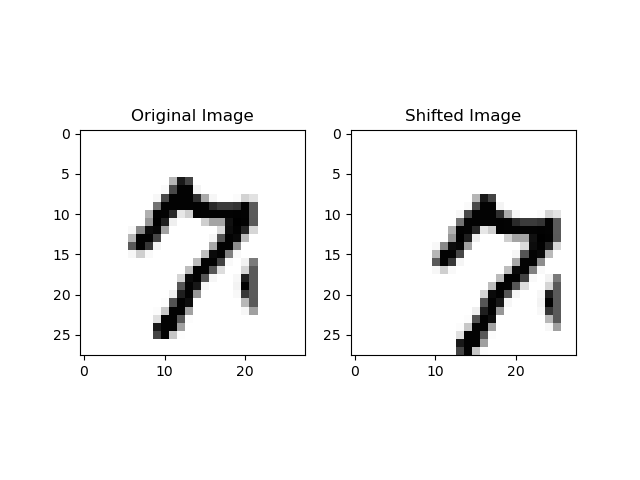

In [85]:
def img_shift(img):
    # Shifts and image between 0 and 5 pixels left and right in both dimensions
    x_trans, y_trans = np.random.randint(-5, 6, (2,))
    img = torch.roll(img, y_trans, -2)
    img = torch.roll(img, x_trans, -1)
    return img

# Show what img_shift does...
random_idx = np.random.randint(0, len(imgs))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_title("Original Image")
ax2.set_title("Shifted Image")
ax1.imshow(imgs[random_idx], cmap="Greys")
ax2.imshow(img_shift(torch.from_numpy(imgs[random_idx])), cmap="Greys")

fig.show()

In [86]:
def img_shift(img):
    x_trans, y_trans = np.random.randint(-5, 6, (2,))
    img = torch.roll(img, y_trans, 0)
    img = torch.roll(img, x_trans, 1)
    return img

print(f"Normal Test Accuracy: {get_accuracy(simple_net, test_loader) * 100:.02f}%")
print(f"Translation Test Accuracy: {get_accuracy(simple_net, test_loader, img_shift) * 100:.02f}%")

Normal Test Accuracy: 73.12%
Translation Test Accuracy: 15.69%


Yikes! Shifting around the numbers destroys the accuracy of our simple fully connected network destroys its performance. Can we fix this through augmentation?

In [87]:
# Train the model...
simple_net = train_model(simple_net, train_loader, test_loader, optimizer, loss_func, n_epochs, img_shift)

Epoch: 1/10, Iter: 300/1120, Loss: 2.3398
Epoch: 1/10, Iter: 600/1120, Loss: 2.3519
Epoch: 1/10, Iter: 900/1120, Loss: 2.3099
Epoch: 1/10, Iter: 1120/1120, Loss: 2.3467
Epoch 1 Train Accuracy: 78.65%
Epoch 1 Test Accuracy: 77.34%

Epoch: 2/10, Iter: 300/1120, Loss: 2.3204
Epoch: 2/10, Iter: 600/1120, Loss: 2.3239
Epoch: 2/10, Iter: 900/1120, Loss: 2.3646
Epoch: 2/10, Iter: 1120/1120, Loss: 2.3065
Epoch 2 Train Accuracy: 77.20%
Epoch 2 Test Accuracy: 76.05%

Epoch: 3/10, Iter: 300/1120, Loss: 2.3124
Epoch: 3/10, Iter: 600/1120, Loss: 1.9205
Epoch: 3/10, Iter: 900/1120, Loss: 2.3808
Epoch: 3/10, Iter: 1120/1120, Loss: 2.3131
Epoch 3 Train Accuracy: 85.86%
Epoch 3 Test Accuracy: 84.59%

Epoch: 4/10, Iter: 300/1120, Loss: 2.3392
Epoch: 4/10, Iter: 600/1120, Loss: 2.2919
Epoch: 4/10, Iter: 900/1120, Loss: 2.2921
Epoch: 4/10, Iter: 1120/1120, Loss: 2.3507
Epoch 4 Train Accuracy: 86.61%
Epoch 4 Test Accuracy: 85.21%

Epoch: 5/10, Iter: 300/1120, Loss: 1.6607
Epoch: 5/10, Iter: 600/1120, Loss:

In [88]:
print(f"Normal Test Accuracy: {get_accuracy(simple_net, test_loader) * 100:.02f}%")
print(f"Translation Test Accuracy: {get_accuracy(simple_net, test_loader, img_shift) * 100:.02f}%")

Normal Test Accuracy: 87.57%
Translation Test Accuracy: 15.24%


# Using a CNN

TODO...

# Using a ResNet

Now that we've looked at a fully connected network and a plain CNN, let's see if we can achieve even better results with a residual network (ResNet).

We'll start by defining a residual block. Let's do a quick recap on what this is.
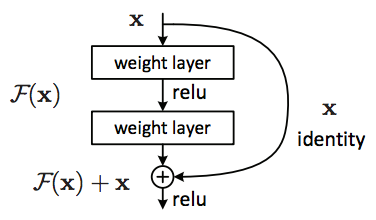
Here we let H(x) be the output of a few stacked nonlinear layers where x is the input to the first of these layers. 
We'll let the stacked layers fit a residual mapping (difference between the input and output) with F(x) = H(x) - x.
Our original function now becomes H(x) = F(x) + x. We expect this to be easier for the solvers to optimize as opposed to the original unreferenced mapping. The main thing recognize (and what makes ResNets differ from CNNs) is the identity shortcut connection which allows the input to be added to the output of the stacked layers.

In [110]:
class ResidualBlock(nn.Module):
    """
    A single residual block.
    """
    def __init__(self, input_size: tuple, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1):
        super().__init__()
        
        if(kernel_size % 2 == 0):
            raise ValueError("Kernel size must be odd!")
            
        self._input_size = input_size
        self._output_size = tuple(int(np.ceil(item / stride)) for item in input_size)
        self._in_channels = in_channels
        self._out_channels = out_channels
        
        self._conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=kernel_size // 2)
        self._relu = nn.ReLU()
        self._conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding=kernel_size // 2)
        
        if(stride == 1):
            self._identity = nn.Identity()
        else:
            self._identity = nn.Conv2d(
                in_channels, out_channels, stride, stride, padding=[item % 2 for item in self._input_size]
            )
        
        self._relu2 = nn.ReLU()
        
    @property
    def output_size(self) -> tuple:
        return self._output_size
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        # Non-Linear part...
        x_nonlinear = self._conv2(self._relu(self._conv1(x)))
        # Linear part...
        x_linear = self._identity(x)
        return self._relu2(x_nonlinear + x_linear)
    
class VanillaBlock(nn.Module):
    """
    A single vanilla block (no skip connections).
    """
    def __init__(self, input_size: tuple, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1):
        super().__init__()
        
        if(kernel_size % 2 == 0):
            raise ValueError("Kernel size must be odd!")
            
        self._input_size = input_size
        self._output_size = tuple(int(np.ceil(item / stride)) for item in input_size)
        self._in_channels = in_channels
        self._out_channels = out_channels
        
        self._conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=kernel_size // 2)
        self._relu = nn.ReLU()
        self._conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding=kernel_size // 2)
        self._relu2 = nn.ReLU()
        
    @property
    def output_size(self) -> tuple:
        return self._output_size
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        x_nonlinear = self._conv2(self._relu(self._conv1(x)))     
        return self._relu2(x_nonlinear)
    

class ResNet(nn.Module):
    def __init__(self, 
        input_size: tuple, 
        in_channels: int,
        hidden_size: int, 
        output_size: int,
        start_depth: int = 64
    ):
        super().__init__()
        
        l_in = start_depth
        
        self._initial_conv = nn.Sequential(
            nn.Conv2d(in_channels, l_in, 7, stride=1, padding=3),  # Modification, remove stride, makes final image too small...
            nn.MaxPool2d(3, 2, padding=1)
        )
        
        # After initial convolutions, input size is 1/2 the original
        input_size = tuple(np.ceil(item / 2) for item in input_size)
        
        # Output dims, kernel size, stride, amount...
        layers = self.get_layers(start_depth)
        
        self._final_layer_len = layers[-1][0]
        
        residual_layers = []
                
        for l_out, kernel, stride, count, block_cls in layers:
            for i in range(count):
                res = block_cls(input_size, l_in, l_out, kernel, stride)
                residual_layers.append(res)
                input_size = res.output_size
            l_in = l_out
        
        self._residual_blocks = nn.Sequential(*residual_layers)
        
        self._final_pooling = nn.AdaptiveAvgPool2d(1)
        
        self._fully_connected = nn.Sequential(
            nn.Linear(self._final_layer_len, hidden_size),
            nn.Linear(hidden_size, output_size),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x: torch.tensor, run_fc: bool=True) -> torch.tensor:
        x = x.reshape(x.shape[0], 1, *(x.shape[1:]))
        x = self._initial_conv(x)
        x = self._residual_blocks(x)
        if(run_fc):
            x = self._final_pooling(x)
            x = x.reshape(-1, self._final_layer_len)
            return self._fully_connected(x)
        else:
            return x
        return self._fully_connected(x) if(run_fc) else x
    
    def get_layers(self, start_depth) -> list:
        raise NotImplementedError("Use one of the ResNet subclasses!")
        

class VanillaNet18(ResNet):
    def get_layers(self, l_in: int) -> list:
        return [
            (l_in, 3, 1, 2, VanillaBlock),
            (l_in * 2, 3, 2, 1, VanillaBlock),
            (l_in * 2, 3, 1, 1, VanillaBlock),
            (l_in * 4, 3, 2, 1, VanillaBlock),
            (l_in * 4, 3, 1, 1, VanillaBlock),
            (l_in * 8, 3, 2, 1, VanillaBlock),
            (l_in * 8, 3, 1, 1, VanillaBlock)
        ]
    
class ResNet18(ResNet):
    def get_layers(self, l_in: int) -> list:
        return [
            (l_in, 3, 1, 2, ResidualBlock),
            (l_in * 2, 3, 2, 1, ResidualBlock),
            (l_in * 2, 3, 1, 1, ResidualBlock),
            (l_in * 4, 3, 2, 1, ResidualBlock),
            (l_in * 4, 3, 1, 1, ResidualBlock),
            (l_in * 8, 3, 2, 1, ResidualBlock),
            (l_in * 8, 3, 1, 1, ResidualBlock)
        ]
    
class VanillaNet34(ResNet):
    def get_layers(self, l_in: int) -> list:
        return [
            (l_in, 3, 1, 3, ResidualBlock),
            (l_in * 2, 3, 2, 1, ResidualBlock),
            (l_in * 2, 3, 1, 3, ResidualBlock),
            (l_in * 4, 3, 2, 1, ResidualBlock),
            (l_in * 4, 3, 1, 5, ResidualBlock),
            (l_in * 8, 3, 2, 1, ResidualBlock),
            (l_in * 8, 3, 1, 2, ResidualBlock)
        ]
    
class ResNet34(ResNet):
    def get_layers(self, l_in: int) -> list:
        return [
            (l_in, 3, 1, 3, ResidualBlock),
            (l_in * 2, 3, 2, 1, ResidualBlock),
            (l_in * 2, 3, 1, 3, ResidualBlock),
            (l_in * 4, 3, 2, 1, ResidualBlock),
            (l_in * 4, 3, 1, 5, ResidualBlock),
            (l_in * 8, 3, 2, 1, ResidualBlock),
            (l_in * 8, 3, 1, 2, ResidualBlock)
        ]

In [111]:
# What values should be here? (Replace with none in final version)
input_size = (28, 28)
in_channels = 1
output_size = 10
channel_start = 64
hidden_layer_size = 1000
model_class = ResNet34


res_net = model_class(input_size, in_channels, hidden_layer_size, output_size, channel_start)
res_net.to(device)

ResNet34(
  (_initial_conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (_residual_blocks): Sequential(
    (0): ResidualBlock(
      (_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_relu): ReLU()
      (_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_identity): Identity()
      (_relu2): ReLU()
    )
    (1): ResidualBlock(
      (_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_relu): ReLU()
      (_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_identity): Identity()
      (_relu2): ReLU()
    )
    (2): ResidualBlock(
      (_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_relu): ReLU()
      (_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_identit

In [112]:
# Set these! (We'll replace these with None in final version)
n_epochs2 = 10
lr2 = 0.001

# Set up everything...
optimizer2 = optim.SGD(res_net.parameters(), lr=lr2, momentum=0.9)
loss_func2 = nn.CrossEntropyLoss()

In [113]:
# Train the model...
res_net = train_model(res_net, train_loader, test_loader, optimizer2, loss_func2, n_epochs2)

Epoch: 1/10, Iter: 300/1120, Loss: 1.7722
Epoch: 1/10, Iter: 600/1120, Loss: 1.8091
Epoch: 1/10, Iter: 900/1120, Loss: 1.6542
Epoch: 1/10, Iter: 1120/1120, Loss: 1.6573
Epoch 1 Train Accuracy: 78.01%
Epoch 1 Test Accuracy: 78.01%

Epoch: 2/10, Iter: 300/1120, Loss: 1.6799
Epoch: 2/10, Iter: 600/1120, Loss: 1.6613
Epoch: 2/10, Iter: 900/1120, Loss: 1.5942
Epoch: 2/10, Iter: 1120/1120, Loss: 1.5748
Epoch 2 Train Accuracy: 86.78%
Epoch 2 Test Accuracy: 86.57%

Epoch: 3/10, Iter: 300/1120, Loss: 1.5794
Epoch: 3/10, Iter: 600/1120, Loss: 1.5434
Epoch: 3/10, Iter: 900/1120, Loss: 1.6570
Epoch: 3/10, Iter: 1120/1120, Loss: 1.5617
Epoch 3 Train Accuracy: 88.34%
Epoch 3 Test Accuracy: 88.02%

Epoch: 4/10, Iter: 300/1120, Loss: 1.7191
Epoch: 4/10, Iter: 600/1120, Loss: 1.5228
Epoch: 4/10, Iter: 900/1120, Loss: 1.5869
Epoch: 4/10, Iter: 1120/1120, Loss: 1.6168
Epoch 4 Train Accuracy: 88.67%
Epoch 4 Test Accuracy: 88.29%

Epoch: 5/10, Iter: 300/1120, Loss: 1.6626
Epoch: 5/10, Iter: 600/1120, Loss:

In [114]:
print(f"Normal Test Accuracy: {get_accuracy(res_net, test_loader) * 100:.02f}%")
print(f"Translation Test Accuracy: {get_accuracy(res_net, test_loader, img_shift) * 100:.02f}%")

Normal Test Accuracy: 98.84%
Translation Test Accuracy: 15.01%


In [115]:
# Retrain using image shifting...
res_net = train_model(res_net, train_loader, test_loader, optimizer2, loss_func2, n_epochs2, img_shift)

Epoch: 1/10, Iter: 300/1120, Loss: 1.7104
Epoch: 1/10, Iter: 600/1120, Loss: 2.3313
Epoch: 1/10, Iter: 900/1120, Loss: 2.3436
Epoch: 1/10, Iter: 1120/1120, Loss: 2.2909
Epoch 1 Train Accuracy: 43.64%
Epoch 1 Test Accuracy: 43.60%

Epoch: 2/10, Iter: 300/1120, Loss: 2.3828
Epoch: 2/10, Iter: 600/1120, Loss: 1.8508
Epoch: 2/10, Iter: 900/1120, Loss: 2.3688
Epoch: 2/10, Iter: 1120/1120, Loss: 2.3099
Epoch 2 Train Accuracy: 95.07%
Epoch 2 Test Accuracy: 94.86%

Epoch: 3/10, Iter: 300/1120, Loss: 2.3365
Epoch: 3/10, Iter: 600/1120, Loss: 2.3528
Epoch: 3/10, Iter: 900/1120, Loss: 2.3428
Epoch: 3/10, Iter: 1120/1120, Loss: 2.3309
Epoch 3 Train Accuracy: 93.31%
Epoch 3 Test Accuracy: 93.27%

Epoch: 4/10, Iter: 300/1120, Loss: 2.3621
Epoch: 4/10, Iter: 600/1120, Loss: 2.3755
Epoch: 4/10, Iter: 900/1120, Loss: 2.2605
Epoch: 4/10, Iter: 1120/1120, Loss: 2.2986
Epoch 4 Train Accuracy: 92.05%
Epoch 4 Test Accuracy: 91.72%

Epoch: 5/10, Iter: 300/1120, Loss: 2.3579
Epoch: 5/10, Iter: 600/1120, Loss:

In [116]:
print(f"Normal Test Accuracy: {get_accuracy(res_net, test_loader) * 100:.02f}%")
print(f"Translation Test Accuracy: {get_accuracy(res_net, test_loader, img_shift) * 100:.02f}%")

Normal Test Accuracy: 96.53%
Translation Test Accuracy: 20.90%
